In [1]:
from numba import cuda

import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from PIL import Image
import cv2
import math
import operator
print(cuda.gpus)

<Managed Device 0>


In [56]:
# [0] là theo trục y, [1] là theo trục x
cell_size = (8, 8)
block_hog_size = (2, 2)
hist_size = 9
n_cell = (height//cell_size[0], width//cell_size[1])
n_block = (n_cell[0] - block_hog_size[0] + 1, n_cell[1] - block_hog_size[1] + 1)
sbin = 40

block_size = (32, 32)
grid_size = (math.ceil(height/block_hog_size[0]), math.ceil(width/block_hog_size[1]))

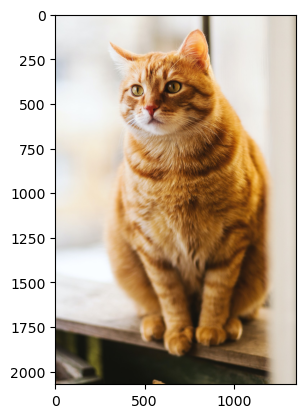

In [12]:
img = Image.open('./Picture/cat-1.jpg')
width = img.size[0] // cell_size[0] * cell_size[0]
height  =  img.size[1] // cell_size[1] * cell_size[1]

img = img.resize((width, height), Image.LANCZOS)
pixel = np.array(img)
plt.imshow(pixel)
plt.show()

In [13]:
height, width, channel = pixel.shape
print("Height: {0}\nWidth: {1}\nChannel: {2}".format(height,width,channel))

Height: 2072
Width: 1352
Channel: 3


# Gray scale

In [25]:
def gray_host(input, channel):
    if channel==1:
        return
    return 0.299*input[:,:,0]+0.587*input[:,:,1]+0.114*input[:,:,2]

In [20]:
@cuda.jit
def gray_kernel(input, width, height, channel, gray):
    row, col = cuda.grid(2)
    if row >= height or col >= width or channel != 3:
        return
    rgb = input[row][col]
    gray[row][col] = 0.299*rgb[0] + 0.587*rgb[1] + 0.114*rgb[2]

In [22]:
# Memory Allocation
gray_dev   = np.empty([height, width],dtype = float)
input_dev   = cuda.to_device(pixel)
gray_device = cuda.device_array_like(gray_dev)

In [23]:
gray_kernel[grid_size, block_size](input_dev, width, height, channel, gray_device)
gray_dev = gray_device.copy_to_host()

Kiểm tra kết quả:

In [26]:
gray = gray_host(pixel, channel)
np.sum(np.abs(gray - gray_dev))

1.380254843752482e-08

# Convolution

In [ ]:
sobel_x = np.array([-1,0,1])
sobel_y = np.array([[-1],
                    [0],
                    [1]])

(259, 169) (258, 168)


In [33]:
def calc_gradient(input, width, height):
  output_x = np.zeros((height,width))
  output_y = np.zeros((height,width))

  for r in range(height):
    for c in range(width):
      for i in range(-1,2):
        pixel_r = r + i
        pixel_r = min(max(0, pixel_r), height - 1)
        output_y[r,c] += input[pixel_r,c] * i

        pixel_c = c + i
        pixel_c = min(max(0, pixel_c), width - 1)
        output_x[r,c] += input[r,pixel_c] * i

  return output_x, output_y

In [31]:
@cuda.jit
def calc_gradient_kernel(input, width, height, output_x, output_y):
  row, col = cuda.grid(2)
  if (row>=height) or (col>=width):
    return
  for i in range(-1,2):
    pixel_r = row + i
    pixel_r = min(max(0, pixel_r), height - 1)
    output_y[row, col] += input[pixel_r,col] * i

    pixel_c = col + i
    pixel_c = min(max(0, pixel_c), width - 1)
    output_x[row,col] += input[row,pixel_c] * i

In [43]:
gradient_x_dev = np.zeros((height, width))
gradient_y_dev = np.zeros((height, width))

gradient_x_device = cuda.to_device(gradient_x_dev)
gradient_y_device = cuda.to_device(gradient_y_dev)

In [44]:
calc_gradient_kernel[grid_size, block_size]\
(gray_device, width, height, gradient_x_device, gradient_y_device)

gradient_x_dev = gradient_x_device.copy_to_host()
gradient_y_dev = gradient_y_device.copy_to_host()

Kiểm tra kết quả

In [46]:
gradient_x, gradient_y = calc_gradient(gray_dev, width, height)
np.sum(np.abs(gradient_x - gradient_x_dev))
np.sum(np.abs(gradient_y - gradient_y_dev))

0.0

# Tìm magnitude và direction

In [47]:
magnitude = np.sqrt(np.square(gradient_x_dev)+np.square(gradient_y_dev))

In [48]:
direction = np.mod(np.add(360, np.rad2deg(np.arctan2(np.array(gradient_y_dev), np.array(gradient_x_dev)))), 360)

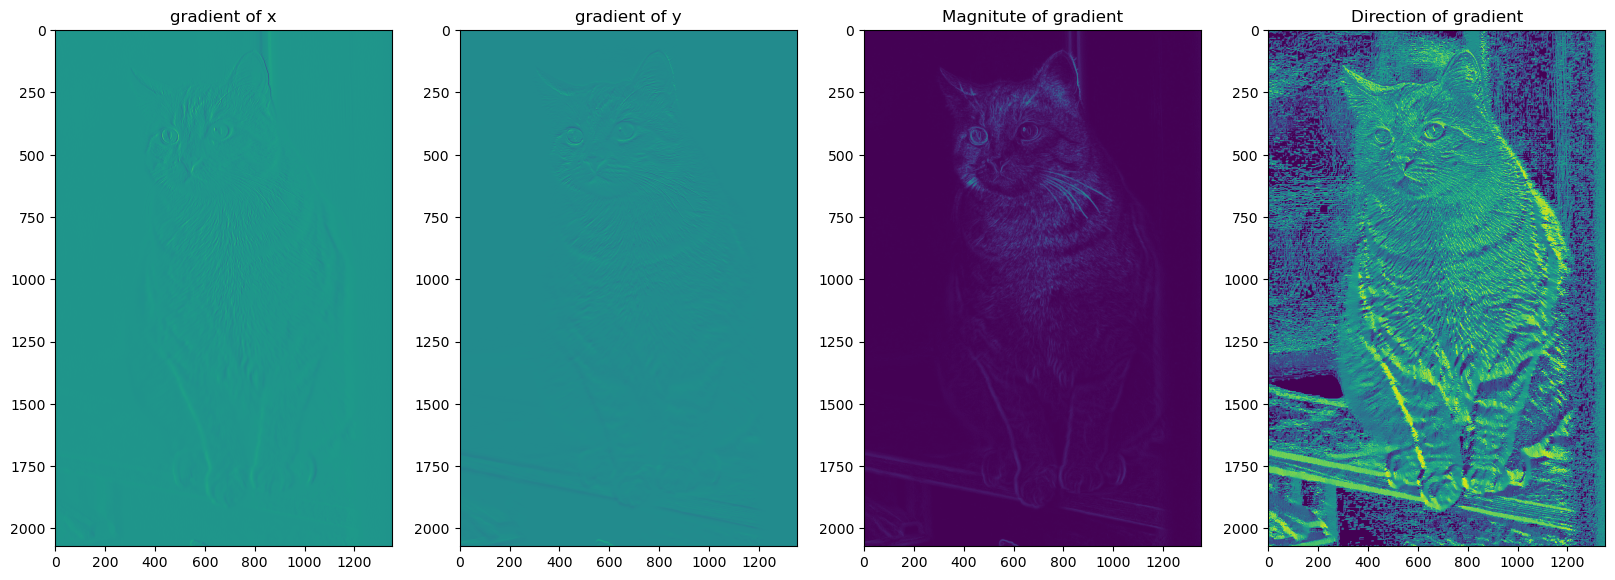

In [49]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 4, 1)
plt.title('gradient of x')
plt.imshow(gradient_x)

plt.subplot(1, 4, 2)
plt.title('gradient of y')
plt.imshow(gradient_y)

plt.subplot(1, 4, 3)
plt.title('Magnitute of gradient')
plt.imshow(magnitude)

plt.subplot(1, 4, 4)
plt.title('Direction of gradient')
plt.imshow(direction)

# Tính histogram

In [61]:
def cell_hist(direction, magnitude, idx, idy, width, height, cell_size, sbin):
    output = np.zeros(9) # output = [0,0,0,0,0,0,0,0,0]
    
    # duyệt qua kích thước cell theo chiều cao
    for r in range(cell_size[0]):
      # duyệt qua kích thước cell theo chiều rộng
        for c in range(cell_size[1]):
          # cột và dòng hiện tại trong ảnh
            cur_r = idy*cell_size[0] + r
            cur_c = idx*cell_size[1] + c
            # kiểm tra
            if cur_r>=height or cur_c >= width:
                break

            # chia lấy phần nguyên và phần dư
            quotient = int(direction[cur_r][cur_c]//sbin)
            remainder = direction[cur_r][cur_c] % sbin

            if remainder==0:
                output[quotient] += magnitude[cur_r][cur_c]
            else:
                first_bin = quotient

                second_bin = first_bin+1

                output[first_bin] += magnitude[cur_r][cur_c]*\
                    ((second_bin*sbin - direction[cur_r][cur_c])/(second_bin*sbin - first_bin*sbin))
                    
                second_bin_idx = second_bin
                if second_bin > 8:
                    second_bin_idx = 0
                output[second_bin_idx] += magnitude[cur_r][cur_c]*\
                    ((direction[cur_r][cur_c] - first_bin*sbin)/(second_bin*sbin - first_bin*sbin))
    return output

In [63]:
def hist_host(direction, magnitude, width, height, cell_size, sbin):
    hist = []
    for y in range(0,n_cell[0]):
        row = []
        for x in range(0,n_cell[1]):
            output = cell_hist(direction,magnitude,x,y,width,height,cell_size,sbin)
            row.append(output)
        hist.append(row)
    return np.array(hist)

In [50]:
@cuda.jit
def hist_kernel(direction, magnitude, width, height, sbin, cell_size, result_out):    
    cur_r, cur_c  = cuda.grid(2)
    
    idy   = int(cur_r//cell_size[0])
    idx   = int(cur_c//cell_size[1])
    # kiểm tra
    if cur_r>=height or cur_c>= width:
        return 
    thread_direction = direction[cur_r][cur_c]
    thread_mag       = magnitude[cur_r][cur_c]
    # chia lấy phần nguyên và phần dư
    quotient  = int(thread_direction//sbin)
    remainder =     thread_direction % sbin

    if remainder==0:
        cuda.atomic.add(result_out, (idy, idx, quotient), thread_mag)
    else:
        first_bin = quotient

        second_bin   = first_bin+1
        need_to_add    = thread_mag*((second_bin*sbin - thread_direction)/(second_bin*sbin - first_bin*sbin))
        cuda.atomic.add(result_out, (idy, idx, first_bin), need_to_add)
        
        second_bin_idx = second_bin
        if second_bin > 8:
            second_bin_idx = 0
        need_to_add_2  = thread_mag*((thread_direction - first_bin*sbin)/(second_bin*sbin - first_bin*sbin))   
        cuda.atomic.add(result_out, (idy, idx, second_bin_idx), need_to_add_2)

In [53]:
# Memory Allocation
hist_dev    = np.empty([n_cell[0], n_cell[1], 9],dtype = np.float64)
d_direction = cuda.to_device(direction)
d_magnitude = cuda.to_device(magnitude)
d_cell_size = cuda.to_device(cell_size)
hist_device = cuda.device_array_like(hist_dev)

In [57]:
hist_kernel[grid_size, block_size]\
    (d_direction, d_magnitude, width, height, sbin, d_cell_size, hist_device)

In [58]:
hist_dev = hist_device.copy_to_host()

Kiểm tra kết quả

In [62]:
hist = hist_host(direction, magnitude, width, height, cell_size, sbin)
np.sum(np.abs(hist-hist_dev))

1.849501711503887e-09

# Chuẩn hóa

In [65]:
final_size = n_block[0] * n_block[1] * block_hog_size[0] * block_hog_size[1] * hist_size

#### 1. Tính chuẩn L2 của mỗi block

In [66]:
l2 = np.empty(n_block)
for i in range(n_block[0]):
  for j in range(n_block[1]):
    l2[i][j] = math.sqrt(np.sum(np.square(hist[i:i+2, j:j+2])))

#### Chuẩn hóa

In [147]:
@cuda.jit()
def normalize_kernel(hist, n_block, block_size, l2, normed):
  row, col  = cuda.grid(2)
  if row >= n_block[0] or col >= n_block[1]:
    return
  for y in range(block_size[0]):
    for x in range(block_size[1]):
      for i in range(9):
        normed[row][col][y][x][i] = hist[row + y][col + x][i]/(l2[row][col]+1)

In [142]:
normed_dev = np.empty((n_block[0], n_block[1], block_hog_size[0], block_hog_size[1], hist_size))

normed_device = cuda.to_device(normed_dev)
l2_dev = cuda.to_device(l2)

In [148]:
normalize_kernel[grid_size, block_size](hist_device, n_block, block_hog_size, l2_dev, normed_device)

normed_dev = normed_device.copy_to_host()

In [144]:
normed_dev = normed_dev.reshape(final_size)

Kiểm tra kết quả

In [145]:
normed_host = np.zeros((n_block[0], n_block[1], block_hog_size[0], block_hog_size[1], hist_size))
for y in range(n_block[0]):
    for x in range(n_block[1]):
        out = hist_dev[y: y + block_hog_size[0], x: x + block_hog_size[1]] / (l2[y][x] + 1)
        normed_host[y][x] = out

In [146]:
np.sum(np.abs(normed_dev - normed_host.reshape(final_size)))

0.0

# So sánh với thư viện

In [137]:
from skimage import feature
H = feature.hog(gray_dev, orientations=9, pixels_per_cell=(8, 8),
                cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2")

print('Kích thước hog features: ', H.shape)

Kích thước hog features:  (1560384,)


In [138]:
np.mean(np.abs(normed_dev - H))

0.1029715143835908